# 3.Optimizing

According to the result of Bayes and random forest, the accuracy is only about 40%, so low for us to predict. As a result we want to find some other algorithms to replace them

# Data preparation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [82]:
train = '/datalab/Corona_NLP_train.csv'
test = '/datalab/Corona_NLP_test.csv'

trainOriginal = pd.read_csv(train, encoding='latin1')
testOriginal = pd.read_csv(test, encoding='latin1')

train = trainOriginal.copy()
test = testOriginal.copy()
covid = pd.concat([train, test])
covid.reset_index(drop=True, inplace=True)


In [83]:
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Positive', 'Positive')
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Negative', 'Negative')
covid = covid.drop('ScreenName', axis=1)
covid = covid.drop('UserName', axis=1)


In [84]:

train['Identity'] = 0
test['Identity'] = 1 
covid = pd.concat([train, test])
covid.reset_index(drop=True, inplace=True)
covid

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0
...,...,...,...,...,...,...,...
44950,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,1
44951,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,1
44952,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,1
44953,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative,1


In [7]:
#train.head()
#test.head()
#train.info()
#test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [56]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
Identity            0
dtype: int64

In [12]:
#train['Location'].value_counts()[:60]

In [86]:
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Positive', 'Positive')
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Negative', 'Negative')

In [87]:
covid['Sentiment'] = covid['Sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})

In [88]:
import re

def clean(text):
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('r<.*?>',' ', text)
    text = text.split()
    text = " ".join([word for word in text if not word in stopWord])
    
    return text

In [89]:
#train['Location'].value_counts()[:60]
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWord = stopwords.words('english')
covid['OriginalTweet'] = covid['OriginalTweet'].apply(lambda x: clean(x))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
covid.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,3799,48751,London,16-03-2020,,0,0
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,1,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,1,0
3,3802,48754,NaN,16-03-2020,"My food stock one empty... PLEASE, panic, THER...",1,0
4,3803,48755,NaN,16-03-2020,"Me, ready go supermarket outbreak. Not I'm par...",2,0


In [91]:
covid = covid[['OriginalTweet','Sentiment','Identity']]
covid.head()

,OriginalTweet,Sentiment,Identity
0,,0,0
1,advice Talk neighbours family exchange phone n...,1,0
2,Coronavirus Australia: Woolworths give elderly...,1,0
3,"My food stock one empty... PLEASE, panic, THER...",1,0
4,"Me, ready go supermarket outbreak. Not I'm par...",2,0


In [92]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [93]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [94]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [95]:
covid['Corpus'] = [nltk.word_tokenize(text) for text in covid.OriginalTweet]
lemma = nltk.WordNetLemmatizer()
covid.Corpus = covid.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
covid.Corpus = covid.apply(lambda x: " ".join(x.Corpus),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [96]:
covid.head()

,OriginalTweet,Sentiment,Identity,Corpus
0,,0,0,
1,advice Talk neighbours family exchange phone n...,1,0,advice Talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths give elderly...,1,0,Coronavirus Australia : Woolworths give elderl...
3,"My food stock one empty... PLEASE, panic, THER...",1,0,"My food stock one empty ... PLEASE , panic , T..."
4,"Me, ready go supermarket outbreak. Not I'm par...",2,0,"Me , ready go supermarket outbreak . Not I 'm ..."


In [97]:
train = covid[covid.Identity==0]
test = covid[covid.Identity==1]
train.drop('Identity',axis=1, inplace=True)
test.drop('Identity',axis=1, inplace=True)
test.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
#train.head()
#test.head()

,OriginalTweet,Sentiment,Corpus
0,TRENDING: New Yorkers encounter empty supermar...,NaN,TRENDING : New Yorkers encounter empty superma...
1,"When I find hand sanitizer Fred Meyer, I turne...",1.0,"When I find hand sanitizer Fred Meyer , I turn..."
2,Find protect loved ones . ?,NaN,Find protect loved one . ?
3,buying hits City anxious shoppers stock food&a...,2.0,buying hit City anxious shopper stock food & a...
4,One week everyone buying baby milk powder next...,0.0,One week everyone buying baby milk powder next...


In [98]:
XTrain = train.Corpus
yTrain = train.Sentiment

XTest = test.Corpus
yTest = test.Sentiment

XTrain, XVal, yTrain, yVal = train_test_split(XTrain, yTrain, test_size=0.2,random_state=42)

XTrain.shape, XVal.shape, yTrain.shape, yVal.shape, XTest.shape, yTest.shape


((32925,), (8232,), (32925,), (8232,), (3798,), (3798,))

In [99]:
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(covid.Corpus)

XTrainVec = vectorizer.transform(XTrain)
XValVec = vectorizer.transform(XVal)
XTestVec = vectorizer.transform(XTest)

# 3.1 LogisticRegression
We find a way using LogisticRegression to classify the text.
But it will take a long time(several hours) to get the result.
The accuracy is finally about 80%

In [100]:
logReg = LogisticRegression(random_state=42)

In [101]:
cross_val_score(LogisticRegression(random_state=42),
                XTrainVec, yTrain, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.4s finished


0.7989068918605282

In [102]:
model = logReg.fit(XTrainVec, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [103]:
print(classification_report(yVal, model.predict(XValVec)))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1553
           1       0.83      0.84      0.83      3617
           2       0.82      0.79      0.80      3062

    accuracy                           0.80      8232
   macro avg       0.78      0.79      0.78      8232
weighted avg       0.80      0.80      0.80      8232



In [104]:
penalty = ['l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logRegGrid = GridSearchCV(logReg, hyperparameters, cv=5, verbose=0)

In [105]:
bestModel = logRegGrid.fit(XTrainVec, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [106]:
print('Best Penalty:', bestModel.best_estimator_.get_params()['penalty'])
print('Best C:', bestModel.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [107]:
yPred = bestModel.predict(XTestVec)

In [108]:
print(classification_report(yTest, bestModel.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       619
           1       0.78      0.81      0.80      1546
           2       0.80      0.78      0.79      1633

    accuracy                           0.77      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.77      0.77      0.77      3798



In [109]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [110]:
lines = []
for line in train['Corpus']:
    lines.append(line)
    
len(lines)

41157

In [111]:
tokenizer = Tokenizer(num_words=5000, lower=True) # Number of words to consider as features
tokenizer.fit_on_texts(train['Corpus'].values)
wordIndex = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % (wordIndex))

Found 33411 unique tokens.


In [112]:
XTrain = tokenizer.texts_to_sequences(train['Corpus'].values)
XTrain = pad_sequences(XTrain, maxlen=30) # Cuts off the texts after this number of words

XTest = tokenizer.texts_to_sequences(test['Corpus'].values)
XTest = pad_sequences(XTest, maxlen=30)

In [113]:
XTrain.shape, XTest.shape

((41157, 30), (3798, 30))

In [114]:
yTrain = to_categorical(train['Sentiment'], 3)
yTest = to_categorical(test['Sentiment'], 3)


In [115]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 128, input_length=1000))
model.add(layers.LSTM(200))
model.add(Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

In [116]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         4276608   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 603       
Total params: 4,540,411
Trainable params: 4,540,411
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])

In [118]:
history = model.fit(XTrain ,yTrain, batch_size=250, epochs=100, validation_split=0.2,
         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
132/132 [==============================] - 48s 346ms/step - loss: 1.1852 - accuracy: 0.4191 - val_loss: 0.6427 - val_accuracy: 0.7513
Epoch 2/100
132/132 [==============================] - 45s 341ms/step - loss: 0.5450 - accuracy: 0.7996 - val_loss: 0.4439 - val_accuracy: 0.8502
Epoch 3/100
132/132 [==============================] - 45s 342ms/step - loss: 0.3940 - accuracy: 0.8684 - val_loss: 0.4416 - val_accuracy: 0.8505
Epoch 4/100
132/132 [==============================] - 46s 347ms/step - loss: 0.3255 - accuracy: 0.8931 - val_loss: 0.4204 - val_accuracy: 0.8608
Epoch 5/100
132/132 [==============================] - 46s 346ms/step - loss: 0.2730 - accuracy: 0.9102 - val_loss: 0.4641 - val_accuracy: 0.8536
Epoch 6/100
132/132 [==============================] - 46s 348ms/step - loss: 0.2347 - accuracy: 0.9207 - val_loss: 0.4858 - val_accuracy: 0.8489
Epoch 7/100
132/132 [==============================] - 46s 346ms/step - loss: 0.1887 - accuracy: 0.9372 - val_loss: 0.5778 -

Text(0.5, 0.98, 'Loss/Accuracy of the LSTM Sentiment Classifier')

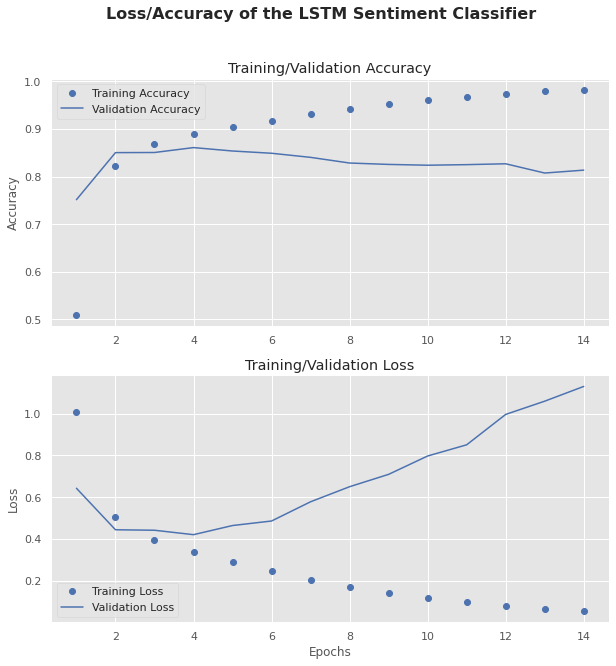

In [119]:
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plot = ax1.plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax1.plot(epochs, valAccuracy, 'b', label='Validation Accuracy')
ax1.set(title='Training/Validation Accuracy', ylabel='Accuracy')
ax1.legend()

plot = ax2.plot(epochs, loss, 'bo', label='Training Loss')
ax2.plot(epochs, valLoss, 'b', label='Validation Loss')
ax2.set(title='Training/Validation Loss', ylabel='Loss', xlabel='Epochs')
ax2.legend()

fig.suptitle('Loss/Accuracy of the LSTM Sentiment Classifier', fontsize=16, fontweight = 'bold')

In [120]:
results = model.evaluate(XTest, yTest)

119/119 [==============================] - 3s 29ms/step - loss: 0.4649 - accuracy: 0.8399


In [121]:
print(classification_report(np.argmax(yTest, 1), model.predict_classes(XTest)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.78      0.81       619
           1       0.80      0.91      0.85      1546
           2       0.89      0.79      0.84      1633

    accuracy                           0.84      3798
   macro avg       0.84      0.83      0.83      3798
weighted avg       0.84      0.84      0.84      3798

